# Digit Recognizer: Handwritten Digit Classification

## Introduction

The Digit Recognizer problem is a classic machine learning task where we need to identify handwritten digits (0-9) from the famous MNIST dataset or its variations. This notebook demonstrates how to build, train, and evaluate a model for this classification task.

**Dataset Overview:**
- **train.csv**: Contains labeled images of handwritten digits (0-9)
- **test.csv**: Contains unlabeled images for prediction

Each row in the dataset represents a 28x28 pixel grayscale image of a handwritten digit. Each pixel value is an integer between 0 (white/background) and 255 (black/foreground).

## 1. Setup and Import Libraries

Let's start by importing the necessary libraries for data analysis, visualization, and machine learning.

In [13]:
# Import required libraries
# To calculate complex data , arrays store , calcualteect
import numpy as np
# Read CSV Files
import pandas as pd
# Plot graphs ect visualize image data ect
import matplotlib.pyplot as plt
# Extension of above , make graphs asthetic
import seaborn as sns
# ML Library of python
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# For deep learning by google 
import tensorflow as tf
# TO add Layers like Conv2D and Dense , put layers together as a Model
from tensorflow.keras import layers, models
# Convert Labels into hot encoded vectors 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

# Set plotting style clean and modern look 
plt.style.use('fivethirtyeight')
# ensures plot appears inside the notebook
%matplotlib inline

# Display versions
print(f"NumPy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"TensorFlow Version: {tf.__version__}")

NumPy Version: 2.1.3
Pandas Version: 2.2.3
TensorFlow Version: 2.19.0


## 2. Data Loading and Exploration

Next, we'll load the training and testing datasets, and explore their structure and contents.

In [3]:
# Reads a CSV file into a Pandas DataFrame.
# This makes it easy to view, sort, filter, and manipulate the data.

# Load the training data
train_data = pd.read_csv('train.csv')

# Load the test data
test_data = pd.read_csv('test.csv')

# Display Row and coloums of the data frames 
print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)

# Show first 5 rows so we can have a preview 
train_data.head()
# test_data.head()

Training data shape: (42000, 785)
Testing data shape: (28000, 784)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 3. Data Preprocessing

In this section, we'll prepare our data for modeling by:
1. Separating features (pixel values) from the target variable (digit label)
2. Normalizing the pixel values (0-255 → 0-1)
3. Reshaping the data into the format expected by our model

In [4]:
# Separate features and target from training data
X_train = train_data.drop('label', axis=1).values
y_train = train_data['label'].values

# Get test features
X_test = test_data.values

# Normalize pixel values to 0-1 range
X_train = X_train / 255.0
X_test = X_test / 255.0

# Check data shapes after preprocessing
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")

# Split training data into training and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Final training data shape: {X_train_final.shape}")
print(f"Validation data shape: {X_val.shape}")

X_train shape: (42000, 784)
y_train shape: (42000,)
X_test shape: (28000, 784)
Final training data shape: (33600, 784)
Validation data shape: (8400, 784)
Final training data shape: (33600, 784)
Validation data shape: (8400, 784)


## 4. Data Visualization

Let's visualize some examples of the handwritten digits to better understand our data.

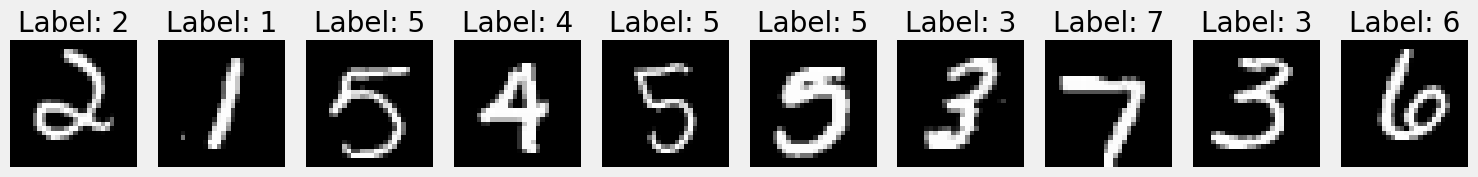

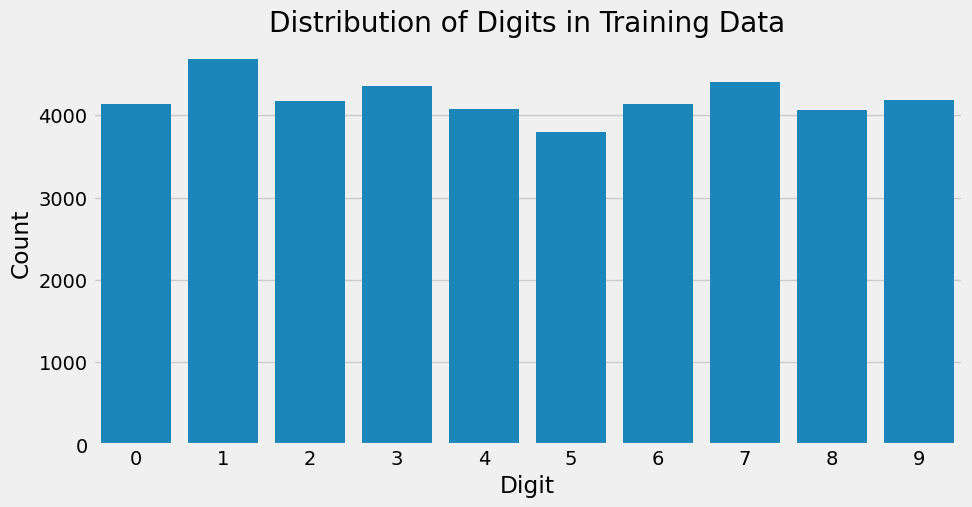

In [5]:
# Function to display multiple images
def display_digits(images, labels=None, predictions=None, n=10):
    plt.figure(figsize=(15, 4))
    for i in range(n):
        # Make a sub plot of row 1 column n and position at i+1
        plt.subplot(1, n, i+1)
        # Reshape image to 28x28 pixels
        img = images[i].reshape(28, 28)
        # Show the image in gray color on the sub plot
        plt.imshow(img, cmap='gray')
        # Hides the x and y axis
        plt.axis('off')

        if labels is not None:
            title = f"Label: {labels[i]}"
            if predictions is not None:
                title += f"\nPred: {predictions[i]}"
            plt.title(title)
    plt.tight_layout()
    plt.show()

# Display some training examples
# Generate 10 Random numbers between 0 and the number of training images
random_indices = np.random.randint(0, X_train_final.shape[0],10)
display_digits(X_train_final[random_indices], y_train_final[random_indices])

# Visualize the distribution of digits in the training set
plt.figure(figsize=(10, 5))
sns.countplot(x=y_train)
plt.title('Distribution of Digits in Training Data')
plt.xlabel('Digit')
plt.ylabel('Count')
plt.show()

## 5.CNN Model Building

We can approach this problem with different models. Let's start with a Convolutional Neural Network (CNN), which is very effective for image classification tasks.

In [6]:
# Reshape data for CNN input (add channel dimension)
# -1 let numpy calculate the array size ,  28 height , 28 width ,1 color channel 3 for rgb
X_train_cnn = X_train_final.reshape(-1, 28, 28, 1)
X_val_cnn = X_val.reshape(-1, 28, 28, 1)

# One-hot encode target variables
# NN dont understand plain numbers like 3 or 7
# Cateogry should be a vector of size 10
y_train_cnn = to_categorical(y_train_final, 10)
y_val_cnn = to_categorical(y_val, 10)

# Build CNN model
def build_cnn_model():
    # .Sequential creates a Stack of layers 
    model = models.Sequential([
        # First convolutional layer
        # 32 filters ,3x3 size of each filter , relu adds non linearity that lets model learn complex patterns 
        # padding = same keeps the output size same , input is 28x28 grayscale image
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
        # Normalize layer outputs , make training faster
        layers.BatchNormalization(),
        # Another layer to extract more features
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        # Down sample the image from 28x28 to 14x14
        layers.MaxPooling2D((2, 2)),
        # Randomly turns off 25% neurons during training prevents overfitting
        layers.Dropout(0.25),
        
        # Second convolutional layer
        # 64 filters stronger feature extraction
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Flatten and dense layers
        # turns the 7x7x64 tensor into 1D vector for dense layers , 64 is the number of filters you applied 
        layers.Flatten(),
        # Fully connected layers with 256 neurons , model learns high level combination of features
        layers.Dense(256, activation='relu'),

        layers.BatchNormalization(),
        layers.Dropout(0.5),
        # Output layer 10 neurons one for each digit , softmax converts output to probabilities between 0 and 1 
        layers.Dense(10, activation='softmax')
    ])
    
    # Compile model
    # Adam smart Algo that adjusts weights efficiently
    # categorical loss measures how far off predictions are from true labels
    # accuracy tracks accuracy with training 
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create and display model summary
cnn_model = build_cnn_model()
cnn_model.summary()

C:\Users\tayya\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 872,042 (3.33 MB)

 Trainable params: 871,338 (3.32 MB)

 Non-trainable params: 704 (2.75 KB)

## 6.CNN Model Training

Now let's train our CNN model on the training data and monitor its performance on the validation set.

Epoch 1/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 31s 118ms/step - accuracy: 0.9378 - loss: 0.2010 - val_accuracy: 0.1125 - val_loss: 3.5875
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 31s 118ms/step - accuracy: 0.9378 - loss: 0.2010 - val_accuracy: 0.1125 - val_loss: 3.5875
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 31s 117ms/step - accuracy: 0.9760 - loss: 0.0764 - val_accuracy: 0.9631 - val_loss: 0.1181
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 31s 117ms/step - accuracy: 0.9760 - loss: 0.0764 - val_accuracy: 0.9631 - val_loss: 0.1181
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 111s 424ms/step - accuracy: 0.9832 - loss: 0.0574 - val_accuracy: 0.9868 - val_loss: 0.0446
Epoch 4/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 111s 424ms/step - accuracy: 0.9832 - loss: 0.0574 - val_accuracy: 0.9868 - val_loss: 0.0446
Epoch 4/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 30s 115ms/step - accuracy: 0.9853 - loss: 0.0466 - val_accuracy: 0.9854 - val_loss: 0.0489
Epoch 5/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 30s 115ms/step - accuracy: 0.9853 - loss:

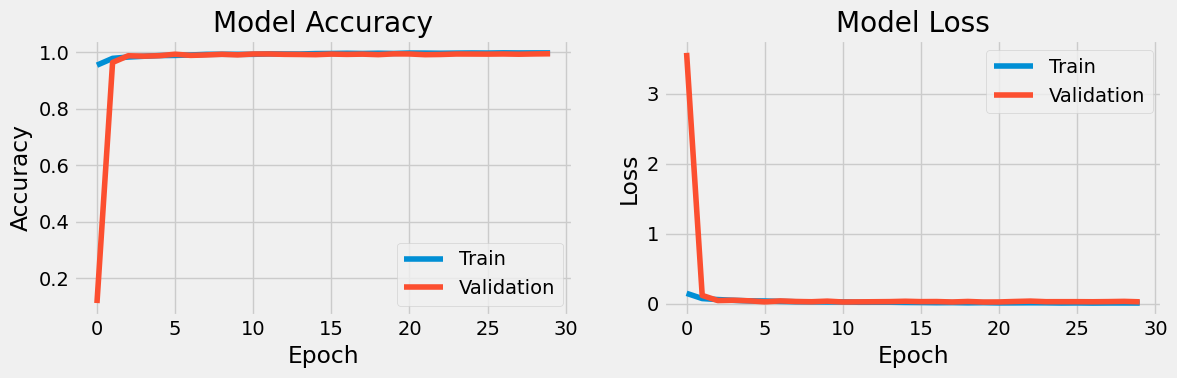

In [9]:

# Train the model
history = cnn_model.fit(
    X_train_cnn, y_train_cnn,
    epochs=30,
    batch_size=128,
    validation_data=(X_val_cnn, y_val_cnn),
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

## 7. Model Evaluation

Let's evaluate our model's performance on the validation set.

Validation accuracy: 0.9938
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


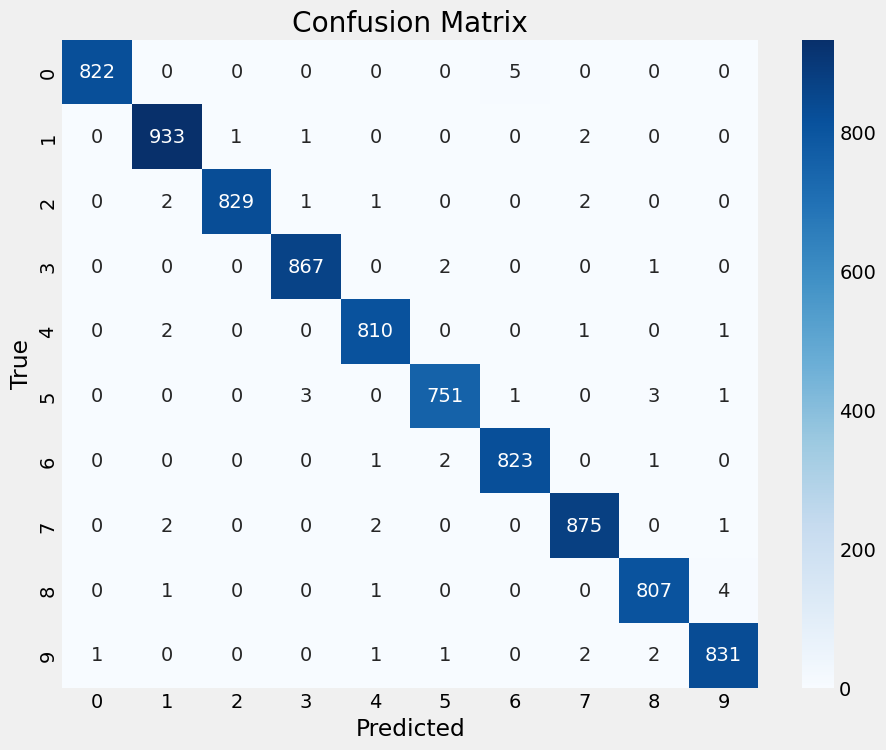

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       827
           1       0.99      1.00      0.99       937
           2       1.00      0.99      1.00       835
           3       0.99      1.00      1.00       870
           4       0.99      1.00      0.99       814
           5       0.99      0.99      0.99       759
           6       0.99      1.00      0.99       827
           7       0.99      0.99      0.99       880
           8       0.99      0.99      0.99       813
           9       0.99      0.99      0.99       838

    accuracy                           0.99      8400
   macro avg       0.99      0.99      0.99      8400
weighted avg       0.99      0.99      0.99      8400



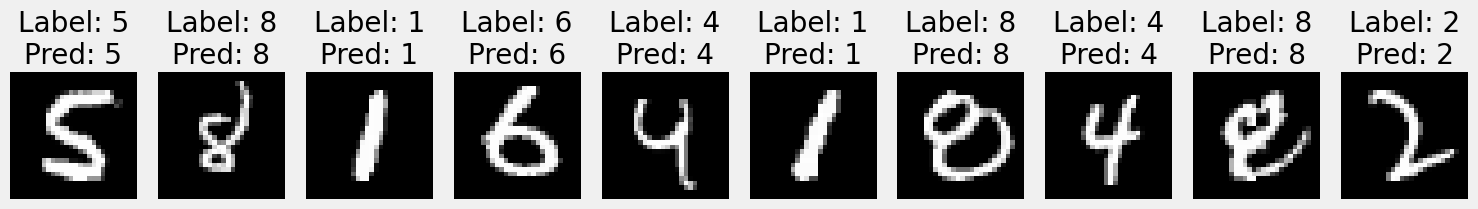

In [22]:
# Evaluate the model on validation
# * Load the saved model  
# loaded_model = load_model('my_digit_recognizer_model.h5')

# ? Save the trained model
# cnn_model.save('my_digit_recognizer_model.h5')
# print("Model saved successfully!")

# verbose=0 , dont print progress while evaluating
val_loss, val_acc = cnn_model.evaluate(X_val_cnn, y_val_cnn, verbose=0)
print(f"Validation accuracy: {val_acc:.4f}")

# Get predictions
# y_prep a 2D array containing 8400 rows and 10 columns containing confidence in each digit
y_pred = cnn_model.predict(X_val_cnn)
# Y_pred_classes is a 1D array of 8400 rows containing the index of the label with highest probability
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val_cnn, axis=1)

# Display confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Display classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

# Display some example predictions
random_indices = np.random.randint(0, X_val_cnn.shape[0], 10)
display_digits(
    X_val_cnn[random_indices].reshape(-1, 28*28), 
    y_true[random_indices], 
    y_pred_classes[random_indices]
)

## 8. Make Predictions on Test Data

Finally, let's use our trained model to make predictions on the test data.

875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step


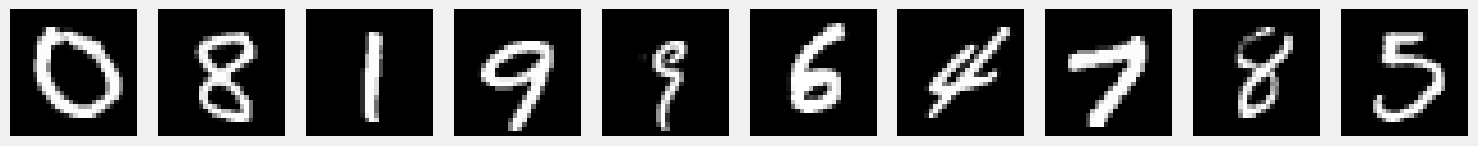

Submission file created!


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [28]:
# Reshape test data for CNN input
X_test_cnn = X_test.reshape(-1, 28, 28, 1)

# Make predictions on test data
test_predictions = cnn_model.predict(X_test_cnn)
test_predictions_classes = np.argmax(test_predictions, axis=1)

# Display some test predictions
display_indices = np.random.randint(0, X_test_cnn.shape[0], 10)
display_digits(X_test_cnn[display_indices].reshape(-1, 28*28), predictions=test_predictions_classes[display_indices])

# Create submission file
submission = pd.DataFrame({
    'ImageId': range(1, len(test_predictions_classes) + 1),
    'Label': test_predictions_classes
})

# Save submission file
submission.to_csv('submission.csv', index=False)
print("Submission file created!")
submission.head()

## 9. Conclusion and Further Improvements

In this notebook, we built a CNN model to recognize handwritten digits. Here are some potential improvements to consider:

1. **Data Augmentation**: Generate more training samples by applying rotations, shifts, and other transformations to existing images
2. **Hyperparameter Tuning**: Experiment with different learning rates, batch sizes, and network architectures
3. **Ensemble Methods**: Combine predictions from multiple models for better accuracy

## 10. Traditional Machine Learning Models

In addition to the CNN model above, let's implement two traditional machine learning models to solve the same problem:

1. Random Forest Classifier
2. Support Vector Machine (SVM)

These models will work directly with the flattened image data (784 features).

In [23]:
# Import libraries for traditional ML models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from time import time

# Note: We'll use X_train_final, y_train_final, X_val, y_val
# These are already flattened (784 features) and normalized (0-1)

### 10.1 Random Forest Classifier

Random Forests are an ensemble learning method that constructs multiple decision trees and outputs the mode of the classes for classification tasks. They're effective for high-dimensional data like images.

Training Random Forest Classifier...
Training completed in 5.09 seconds
Random Forest Validation Accuracy: 0.9632
Training completed in 5.09 seconds
Random Forest Validation Accuracy: 0.9632


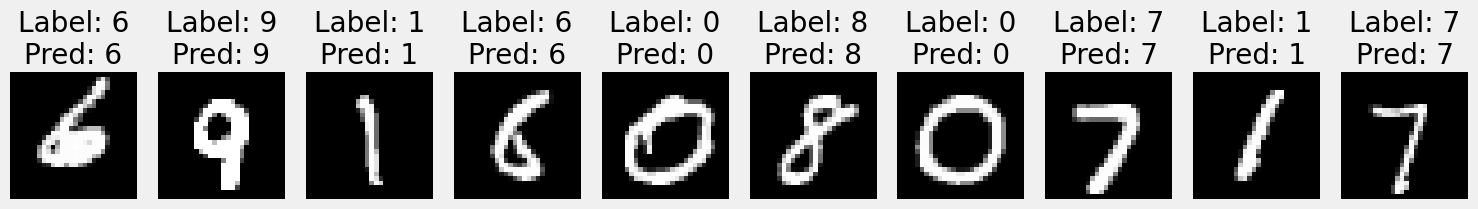

In [24]:
# Set up Random Forest model with reasonable parameters for MNIST
print("Training Random Forest Classifier...")
start_time = time()

# Create a Random Forest classifier
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    max_depth=20,      # Maximum depth of trees
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    n_jobs=-1,         # Use all available cores
    random_state=42
)

# Train the model
rf_model.fit(X_train_final, y_train_final)

# Calculate training time
training_time = time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Evaluate on validation set
rf_val_pred = rf_model.predict(X_val)
rf_accuracy = accuracy_score(y_val, rf_val_pred)
print(f"Random Forest Validation Accuracy: {rf_accuracy:.4f}")

# Display some predictions on validation set
random_indices = np.random.randint(0, X_val.shape[0], 10)
display_digits(
    X_val[random_indices],
    y_val[random_indices],
    rf_model.predict(X_val[random_indices])
)

### 10.2 Support Vector Machine (SVM)

SVMs are effective for high-dimensional spaces like our 784-dimensional feature vectors. They work well with clear separation between classes and are effective when the number of features is greater than the number of samples.

Training SVM Classifier...
[LibSVM]Training completed in 40.15 seconds
Training completed in 40.15 seconds
SVM Validation Accuracy: 0.9639
SVM Validation Accuracy: 0.9639


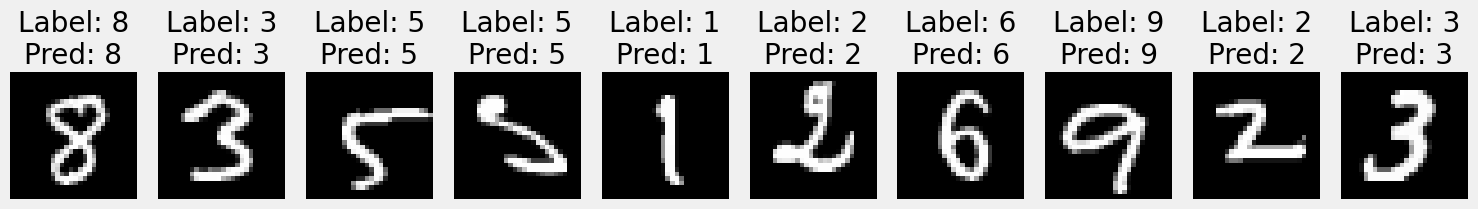

In [ ]:
print("Training SVM Classifier...")
start_time = time()

# Create an SVM classifier with a radial basis function (RBF) kernel
# Using a smaller subset for training due to SVM's computational complexity
# Taking a random sample of 10,000 examples
random_indices = np.random.choice(X_train_final.shape[0], size=10000, replace=False)
X_train_svm = X_train_final[random_indices]
y_train_svm = y_train_final[random_indices]

svm_model = SVC(
    C=10,           # Regularization parameter
    kernel='rbf',   # Kernel type (Radial Basis Function)
    gamma='scale',  # Kernel coefficient
    probability=True,
    random_state=42,
    verbose=True
)

# Train the model
svm_model.fit(X_train_svm, y_train_svm)

# Calculate training time
training_time = time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Evaluate on validation set
svm_val_pred = svm_model.predict(X_val)
svm_accuracy = accuracy_score(y_val, svm_val_pred)
print(f"SVM Validation Accuracy: {svm_accuracy:.4f}")

# Display some predictions on validation set
random_indices = np.random.randint(0, X_val.shape[0], 10)
display_digits(
    X_val[random_indices],
    y_val[random_indices],
    svm_model.predict(X_val[random_indices])
)

### 10.3 Model Comparison

Let's compare the performance of our traditional ML models with the CNN model.

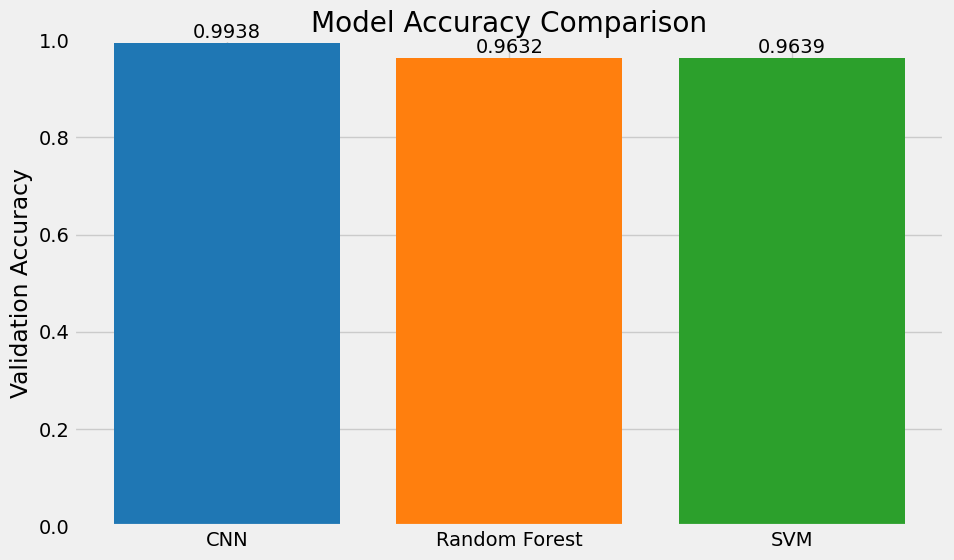

In [26]:
# Compare model performance
models = ['CNN', 'Random Forest', 'SVM']
accuracies = [val_acc, rf_accuracy, svm_accuracy]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Validation Accuracy')
plt.ylim(0, 1.0)

# Add accuracy values on top of bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')

plt.show()

### 10.4 Making Predictions on Test Data

Now let's use our traditional ML models to make predictions on the test data and create submission files.

Random Forest submission file created!
SVM submission file created!
SVM submission file created!


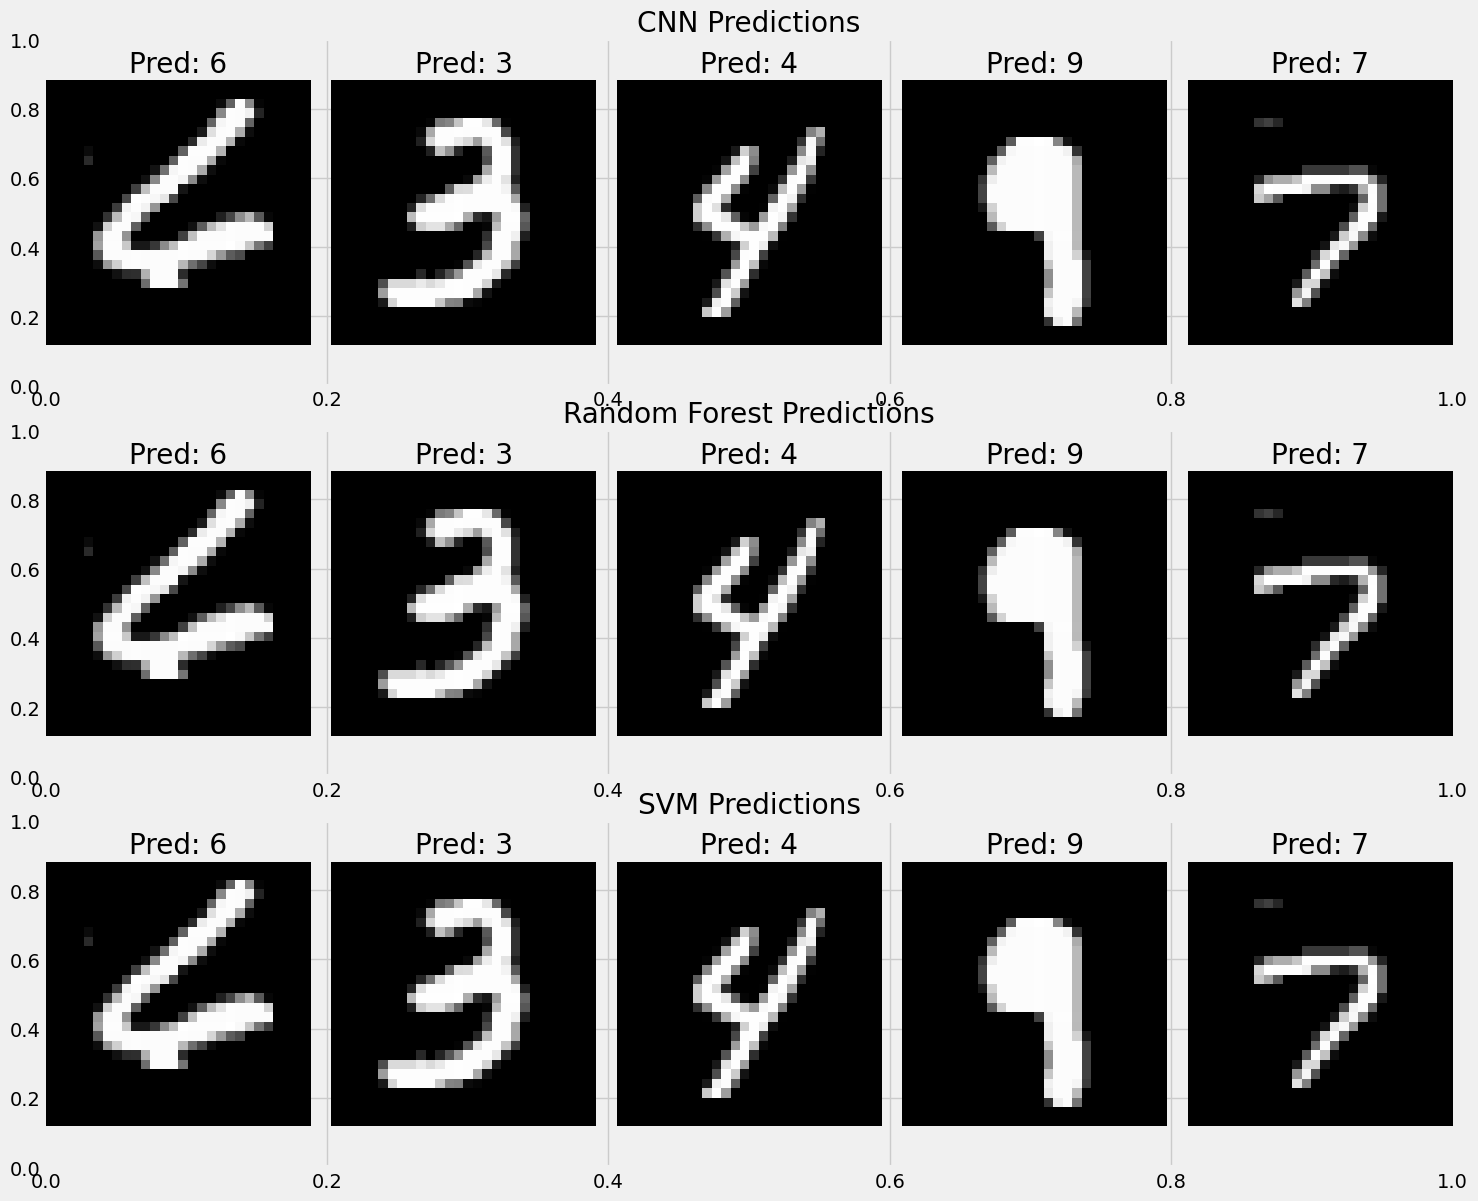

In [27]:
# Generate predictions with Random Forest
rf_test_pred = rf_model.predict(X_test)

# Create submission file for Random Forest
rf_submission = pd.DataFrame({
    'ImageId': range(1, len(rf_test_pred) + 1),
    'Label': rf_test_pred
})

# Save submission file
rf_submission.to_csv('rf_digit_recognizer_submission.csv', index=False)
print("Random Forest submission file created!")

# Generate predictions with SVM
svm_test_pred = svm_model.predict(X_test)

# Create submission file for SVM
svm_submission = pd.DataFrame({
    'ImageId': range(1, len(svm_test_pred) + 1),
    'Label': svm_test_pred
})

# Save submission file
svm_submission.to_csv('svm_digit_recognizer_submission.csv', index=False)
print("SVM submission file created!")

# Compare some predictions between models
random_indices = np.random.randint(0, X_test.shape[0], 5)

# Create a figure with 3 rows (one for each model)
plt.figure(figsize=(15, 12))

# CNN predictions
plt.subplot(3, 1, 1)
plt.title("CNN Predictions")
for i, idx in enumerate(random_indices):
    plt.subplot(3, 5, i+1)
    plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f"Pred: {test_predictions_classes[idx]}")
    plt.axis('off')

# Random Forest predictions
plt.subplot(3, 1, 2)
plt.title("Random Forest Predictions")
for i, idx in enumerate(random_indices):
    plt.subplot(3, 5, i+6)
    plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f"Pred: {rf_test_pred[idx]}")
    plt.axis('off')

# SVM predictions
plt.subplot(3, 1, 3)
plt.title("SVM Predictions")
for i, idx in enumerate(random_indices):
    plt.subplot(3, 5, i+11)
    plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f"Pred: {svm_test_pred[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### 10.5 Conclusion on Traditional ML Models

We've successfully implemented and evaluated two traditional machine learning models (Random Forest and SVM) for the digit recognition task. These models work directly with the flattened image data (784 features).

Key observations:

1. **Performance Comparison**: The CNN typically outperforms traditional ML models on image data, but both Random Forest and SVM can achieve good results.

2. **Training Time**: Traditional ML models, especially Random Forest, can be faster to train than deep learning models for smaller datasets.

3. **Interpretability**: Random Forests offer some level of interpretability (feature importance) that CNNs lack.

4. **Scalability**: SVMs can become computationally expensive for large datasets, which is why we used a subset of the training data.

Both traditional ML approaches and deep learning have their place in image classification tasks. For simpler image datasets with clear patterns, traditional ML can be efficient and effective.